# **Skim-Text**
**Project Summary:**
> This Project builds a nlp model for classifying Medical Data so that it becomes easy to skim.

**Steps:**
1. Downloading a text dataset (https://github.com/Franck-Dernoncourt/pubmed-rct)
2. Writing a preprocessing function to prepare our data for modelling
3. Setting up a series of modelling experiments   
        a) Making a baseline (TF-IDF classifier)           
        b) Deep models with different combinations of: token embeddings, character embeddings, pretrained embeddings, positional embeddings
4. Compare all the 6 model and save the best model
5. Making predictions on PubMed abstracts from the wild





In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2026-02-23 12:48:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2026-02-23 12:48:01 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



**Step 1:**  Downloading our Dataset

We use the PubMed 200k RCT dataset https://github.com/Franck-Dernoncourt/pubmed-rct .

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 36.38 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [10]:
data_dir="/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()
train_lines = get_lines(data_dir+"train.txt")
test_lines=get_lines(data_dir+"test.txt")


**Step 2:**  Preprocessing

We create a function to store text along with target ,line number, total lines in a dictionary     
[{    
  'line_number': 0,   
  'target': 'OBJECTIVE',        
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',      
  'total_lines': 11},
  ...]

In [11]:
import pandas as pd
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []


    for line in input_lines:
      if line.startswith("###"):
        abstract_id = line
        abstract_lines = ""
      elif line.isspace():
        abstract_line_split = abstract_lines.splitlines()
        for abstract_line_number, abstract_line in enumerate(abstract_line_split):
          line_data = {}
          target_text_split = abstract_line.split("\t")
          line_data["target"] = target_text_split[0]
          line_data["text"] = target_text_split[1].lower()
          line_data["line_number"] = abstract_line_number
          line_data["total_lines"] = len(abstract_line_split) - 1
          abstract_samples.append(line_data)
      else:
        abstract_lines += line


    return abstract_samples

train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)


train_df[:20]

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [12]:
train_sentences=train_df["text"].to_list()
test_sentences=test_df["text"].to_list()
val_sentences=val_df["text"].to_list()

train_sentences[:20]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .',
 'participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'primary outcomes are domain sp

In [17]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

**Step 3:** Building Model

Model 0: BaseLine

In [18]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())

class_names = label_encoder.classes_
num_classes=len(class_names)
print((class_names,num_classes))

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object), 5)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([("tf_idf",TfidfVectorizer()),
                  ("clf",MultinomialNB())])

model_0.fit(train_sentences,train_labels_encoded)
model_0.score(val_sentences,val_labels_encoded)
baseline_preds=model_0.predict(test_sentences)

In [20]:
from helper_functions import calculate_results
baseline_results=calculate_results(test_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 73.39029600244126,
 'precision': 0.7290729787685353,
 'recall': 0.7339029600244126,
 'f1': 0.7163130142530599}

Model 1: Conv1D

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [22]:
sent_lens=[len(sentence.split()) for sentence in train_sentences]
output_seq_len = int(np.percentile(sent_lens, 95))
max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)
text_vectorizer.adapt(train_sentences)

rct_20k_text_vocab = text_vectorizer.get_vocabulary()

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(train_sentences,axis=-1), train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(val_sentences,axis=-1), val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.expand_dims(test_sentences,axis=-1), test_labels_one_hot))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [24]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [25]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset)

Epoch 1/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6096 - loss: 0.9795 - val_accuracy: 0.7756 - val_loss: 0.6178
Epoch 2/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7883 - loss: 0.6043 - val_accuracy: 0.7964 - val_loss: 0.5674
Epoch 3/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.7949 - loss: 0.5793 - val_accuracy: 0.8041 - val_loss: 0.5486


In [26]:
model_1_pred_probs = model_1.predict(test_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

922/922 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


{'accuracy': 80.56148916692096,
 'precision': 0.8037363799154553,
 'recall': 0.8056148916692096,
 'f1': 0.8039868012486642}

Model 2: Pretrained Embeddings (GloVe)

In [27]:
import os

# Only the TensorFlow backend supports string inputs.
os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import numpy as np
import tensorflow.data as tf_data
import keras
from keras import layers

In [28]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2026-02-23 12:57:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.05MB/s    in 2m 40s  

2026-02-23 12:59:41 (5.15 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [29]:
x_train = text_vectorizer(np.array([[s] for s in train_sentences])).numpy()
x_val = text_vectorizer(np.array([[s] for s in val_sentences])).numpy()
x_test=text_vectorizer(np.array([[s] for s in test_sentences])).numpy()


In [30]:
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [34]:
num_tokens = len(rct_20k_text_vocab) + 2
embedding_dim = 100
hits = 0
misses = 0
word_index = dict(zip(rct_20k_text_vocab, range(len(rct_20k_text_vocab))))

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1


In [35]:
from keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    trainable=False,
)
embedding_layer.build((1,))
embedding_layer.set_weights([embedding_matrix])

In [33]:
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embedded_sequences)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = keras.Model(int_sequences_input, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"],
                jit_compile=False)

In [36]:
model_2_history = model_2.fit(x_train,train_labels_one_hot,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=(x_val,val_labels_one_hot))

Epoch 1/3
1070/1073 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6295 - loss: 0.9863

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6297 - loss: 0.9859 - val_accuracy: 0.7229 - val_loss: 0.7526
Epoch 2/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7322 - loss: 0.7405 - val_accuracy: 0.7517 - val_loss: 0.6885
Epoch 3/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7570 - loss: 0.6781 - val_accuracy: 0.7679 - val_loss: 0.6415


In [37]:
model_2_pred_probs = model_2.predict(x_test)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

922/922 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


{'accuracy': 76.49950835791543,
 'precision': 0.7598737161323689,
 'recall': 0.7649950835791544,
 'f1': 0.7592476212737777}

Model 3: Custom Character embeddings

Before getting on we need to split the sentences into characters . we create a seperate function for that and store it in a seperate dataset . We create a new vectorizer and a new embedding layer

In [38]:
import string
def split_chars(text):
  return " ".join(list(text))

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]


char_lens = [len(sentence) for sentence in train_sentences]
output_seq_char_len = int(np.percentile(char_lens, 95))
alphabet = string.ascii_lowercase + string.digits + string.punctuation
char_vectorizer=TextVectorization(max_tokens=28,
                                   output_sequence_length=output_seq_char_len,
                                  standardize="lower_and_strip_punctuation")

char_vectorizer.adapt(train_chars) # Add this line to adapt the vectorizer

char_embed=layers.Embedding(input_dim=28,
                            output_dim=128,
                            mask_zero=False)

train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [39]:
from ast import Global
inputs=layers.Input(shape=(), dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5, padding="same",activation='relu')(char_embeddings)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_3=tf.keras.Model(inputs=inputs,outputs=outputs)
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [40]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4013 - loss: 1.3880 - val_accuracy: 0.4851 - val_loss: 1.2416
Epoch 2/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4902 - loss: 1.2435 - val_accuracy: 0.5153 - val_loss: 1.1923
Epoch 3/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5142 - loss: 1.1859 - val_accuracy: 0.5441 - val_loss: 1.1343


In [41]:
model_3_pred_probs = model_3.predict(test_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

922/922 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


{'accuracy': 53.761909605669146,
 'precision': 0.5081049733209226,
 'recall': 0.5376190960566914,
 'f1': 0.4981185246607843}

Model 4: pretrained token embeddings + character embeddings

In [46]:
train_t_c_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_t_c_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_t_c_dataset=tf.data.Dataset.zip((train_t_c_data,train_t_c_labels))
train_t_c_dataset=train_t_c_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_t_c_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
test_t_c_labels=tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_t_c_dataset=tf.data.Dataset.zip((test_t_c_data,test_t_c_labels))
test_t_c_dataset=test_t_c_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_t_c_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_t_c_labels=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_t_c_dataset=tf.data.Dataset.zip((val_t_c_data,val_t_c_labels))
val_t_c_dataset=val_t_c_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [47]:
t_inputs=layers.Input(shape=[],dtype=tf.string)
t_vectors = text_vectorizer(t_inputs)
t_embedd=embedding_layer(t_vectors)
t_pooled = layers.GlobalAveragePooling1D()(t_embedd)
t_outputs=layers.Dense(128,activation="relu")(t_pooled)
t_model=tf.keras.Model(inputs=t_inputs,outputs=t_outputs)

c_inputs=layers.Input(shape=(),dtype=tf.string)
c_vectors=char_vectorizer(c_inputs)
c_embedd=char_embed(c_vectors)
c_x=layers.Bidirectional(layers.LSTM(64))(c_embedd)
c_model=tf.keras.Model(inputs=c_inputs,outputs=c_x)

t_c_concat=layers.Concatenate()([t_model.output,c_model.output])
t_c_x=layers.Dropout(0.5)(t_c_concat)
t_c_x=layers.Dense(128,activation="relu")(t_c_x)
t_c_x=layers.Dropout(0.5)(t_c_x)
t_c_outputs=layers.Dense(num_classes,activation="softmax")(t_c_x)

model_4=tf.keras.Model(inputs=[t_model.input,c_model.input],outputs=t_c_outputs)

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),metrics=["Accuracy"])



In [48]:
model_4_history = model_4.fit(train_t_c_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_t_c_dataset)),
                              epochs=3,
                              validation_data=val_t_c_dataset,
                              validation_steps=int(0.1 * len(val_t_c_dataset)))

Epoch 1/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - Accuracy: 0.5162 - loss: 1.1643 - val_Accuracy: 0.6948 - val_loss: 0.7780
Epoch 2/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - Accuracy: 0.6743 - loss: 0.8480 - val_Accuracy: 0.7250 - val_loss: 0.7231
Epoch 3/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - Accuracy: 0.6966 - loss: 0.7926 - val_Accuracy: 0.7191 - val_loss: 0.7091


In [49]:
model_4_pred_probs=model_4.predict(test_t_c_dataset)
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_results=calculate_results(y_true=test_labels_encoded,y_pred=model_4_preds)
model_4_results

922/922 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


{'accuracy': 72.60366866714135,
 'precision': 0.7288224221413299,
 'recall': 0.7260366866714135,
 'f1': 0.722265309006706}

Model 5: Character embedding+pretrained token embeddings+ positional embedding

In [50]:
d1=np.percentile(train_df.line_number, 98)
d1=int(d1)
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=d1)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=d1)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=d1)

d2=np.percentile(train_df.total_lines, 98)
d2=int(d2)
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=d2)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=d2)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=d2)

train_pos_char_token_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_pos_char_token_label=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset=tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_label))
train_pos_char_token_dataset=train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,val_chars))
val_pos_char_token_label=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset=tf.data.Dataset.zip((val_pos_char_token_data,val_pos_char_token_label))
val_pos_char_token_dataset=val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,test_total_lines_one_hot,test_sentences,test_chars))
test_pos_char_token_label=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset=tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_label))
test_pos_char_token_dataset=test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [51]:
char_inputs=tf.keras.layers.Input(shape=(),dtype=tf.string)
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_x=layers.Bidirectional(layers.LSTM(64))(char_embeddings)
char_x=layers.Dense(128,activation="relu")(char_x)
char_outputs=layers.Dropout(0.5)(char_x)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_outputs)

token_inputs=tf.keras.layers.Input(shape=[],dtype=tf.string)
token_vectors = text_vectorizer(token_inputs)
token_embeddings=embedding_layer(token_vectors)
Pooling_Layer=layers.GlobalAveragePooling1D()(token_embeddings)
token_output=layers.Dense(128,activation="relu")(Pooling_Layer)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_output)

line_number_inputs = layers.Input(shape=(int(d1),), dtype=tf.float32)
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

total_lines_inputs = layers.Input(shape=(int(d2),), dtype=tf.float32)
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

concat_embeddings=layers.Concatenate()([token_model.output,
                                        char_model.output])
z = layers.Dense(256, activation="relu")(concat_embeddings)
z = layers.Dropout(0.5)(z)
z=layers.Concatenate()([line_number_model.output,
                        total_line_model.output,
                        z])
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(z)
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"],jit_compile=False)


In [52]:
early_stopping  = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss' ,
                                                   patience = 3, min_delta = 0.5 , verbose = 1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [54]:
model_5_history=model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
                              callbacks = [early_stopping,
                                   reduce_lr])

Epoch 1/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.6290 - loss: 0.9235 - val_accuracy: 0.7944 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 2/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.7966 - loss: 0.5215 - val_accuracy: 0.8184 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 3/3
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.8137 - loss: 0.4731 - val_accuracy: 0.8344 - val_loss: 0.4346 - learning_rate: 0.0010


In [55]:
model_5_pred_probs = model_5.predict(test_pos_char_token_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

922/922 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


{'accuracy': 83.21296578849218,
 'precision': 0.8348523488745302,
 'recall': 0.8321296578849219,
 'f1': 0.8308916535243616}

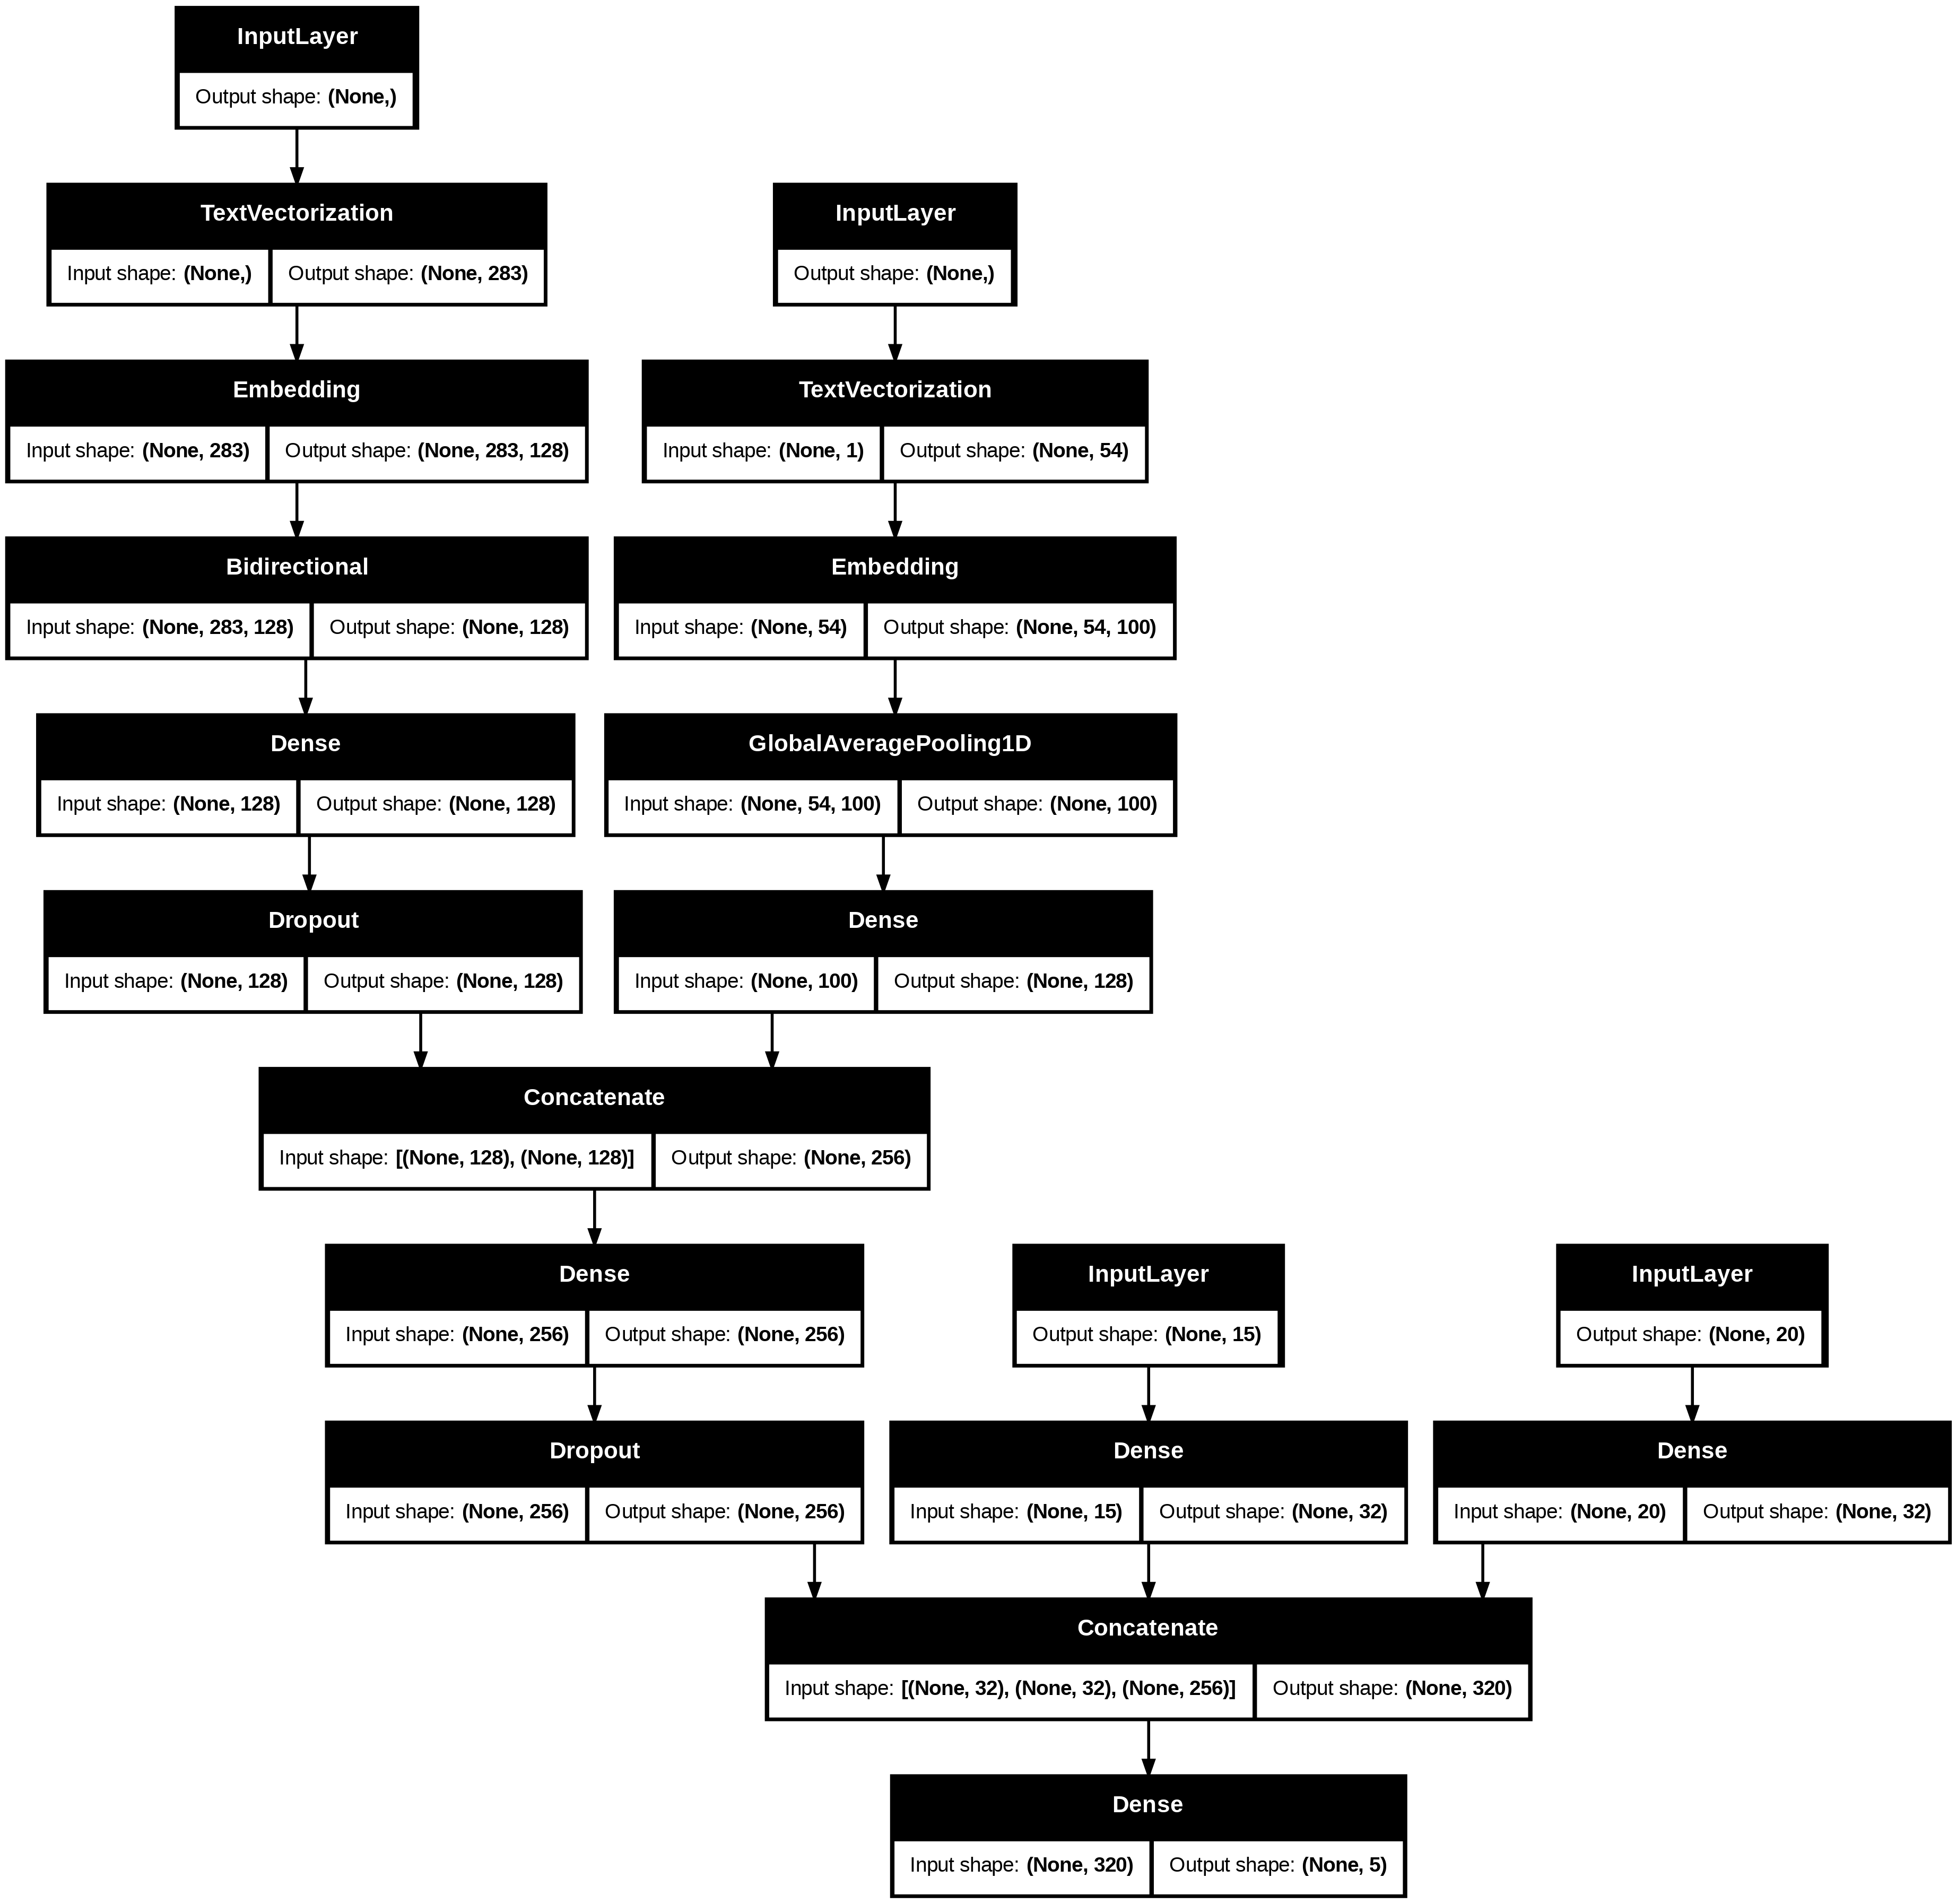

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model_5,show_shapes=True)

**Step 4:** Evaluation

In [61]:
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "Conv1D": model_1_results,
                                  "Pretrained Embeddings (GloVe)": model_2_results,
                                  "character embeddings": model_3_results,
                                  "pretrained token embeddings + character embeddings": model_4_results,
                                  "Character embedding+pretrained token embeddings+ positional embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,73.390296,0.729073,0.733903,0.716313
Conv1D,80.561489,0.803736,0.805615,0.803987
Pretrained Embeddings (GloVe),76.499508,0.759874,0.764995,0.759248
character embeddings,53.761910,0.508105,0.537619,0.498119
pretrained token embeddings + character embeddings,72.603669,0.728822,0.726037,0.722265
Character embedding+pretrained token embeddings+ positional embedding,83.212966,0.834852,0.832130,0.830892


In [62]:
model_5.save("skimlit_tribrid_model.keras")

In [63]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/skimlit_tribrid_model.keras /content/drive/MyDrive/skimlit_tribrid_model.keras

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step 5:** Testing on New Text

In [64]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/skimlit_tribrid_model.keras")

We download an abstract data

In [65]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)



--2026-02-23 13:13:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2026-02-23 13:13:29 (77.7 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [66]:
from spacy.lang.en import English
nlp = English()

sentencizer = nlp.add_pipe("sentencizer")

doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)]


we have to convert the text into a form which is compatible with our model

In [67]:
total_lines_in_sample = len(abstract_lines)

sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]

**FINAL OUTPUT**

In [68]:
%%time
test_abstract_pred_probs = loaded_model.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))

test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
BACKGROUND: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatm